In [1]:
from ciw.dists import Exponential
from kmodes.kprototypes import KPrototypes
from scipy import special, stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.utils import KneeLocator

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("default")
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']


In [2]:
clinicals = [
    "n_spells",
    "n_wards",
    "n_consultants",
    "true_los",
    "n_pr_attendances",
    "n_sn_attendances",
    "n_copd_admissions_last_year",
    "charlson_gross",
    "n_icds",
    "intervention",
    "day_of_week",
    "gender",
]

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

cols = clinicals + codes + conditions

In [3]:
knee_results = pd.read_csv("../data/clusters/knee_results.csv", header=None).set_index(0)
with open("../data/clusters/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

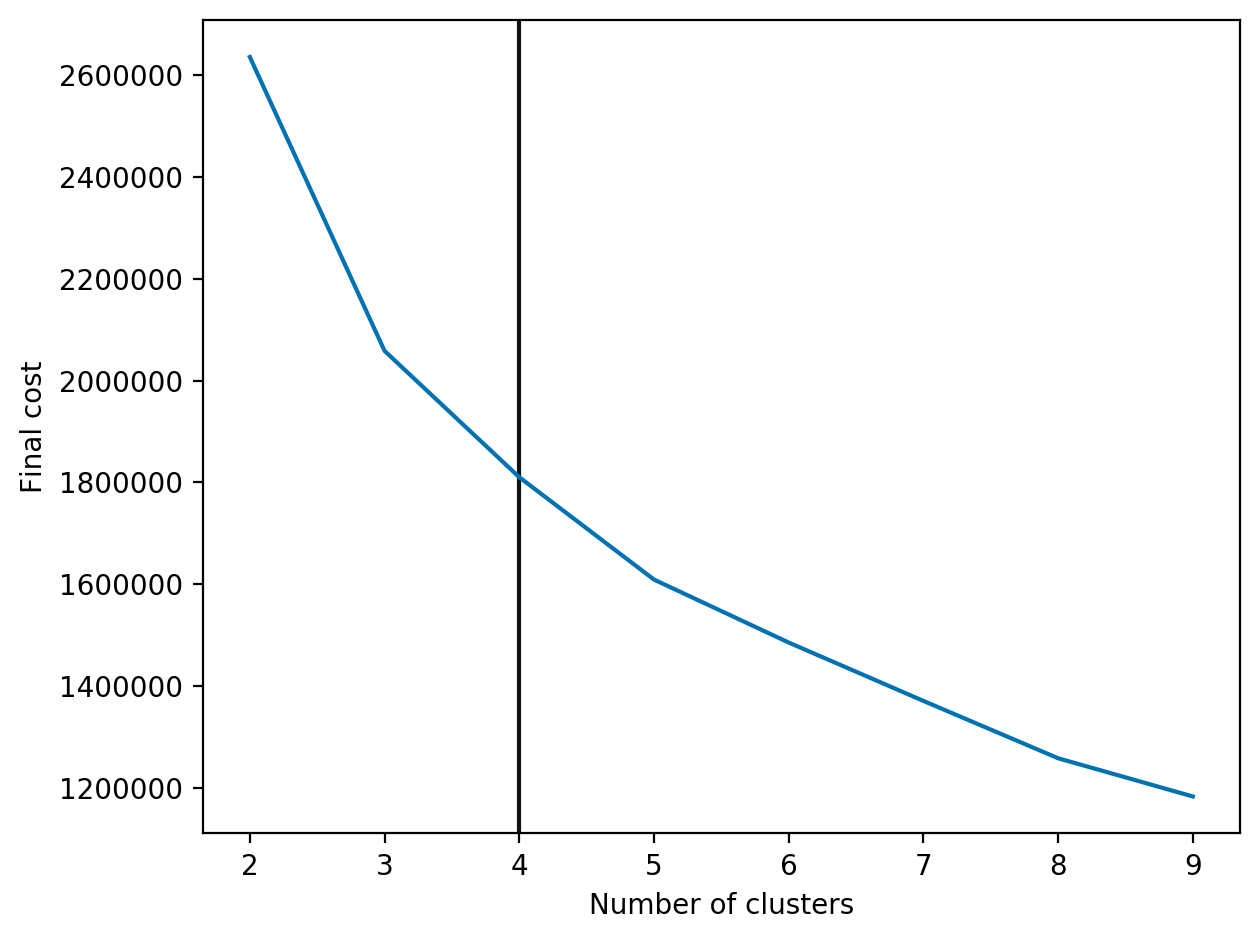

In [4]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)

ax.set(
    xlabel="Number of clusters",
    ylabel="Final cost",
    ylim=ylims,
)

plt.tight_layout()
plt.savefig("../img/knee_results.pdf", transparent=True)

In [5]:
copd = pd.read_csv("../data/clusters/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])
copd = copd.dropna(subset=["cluster"])
copd["cluster"] = copd["cluster"].astype(int)

In [6]:
copd["cluster"].value_counts().sort_index()

0    1084
1    2096
2    7540
3     157
Name: cluster, dtype: int64

In [7]:
kde_ylims = (-0.01, 0.18)

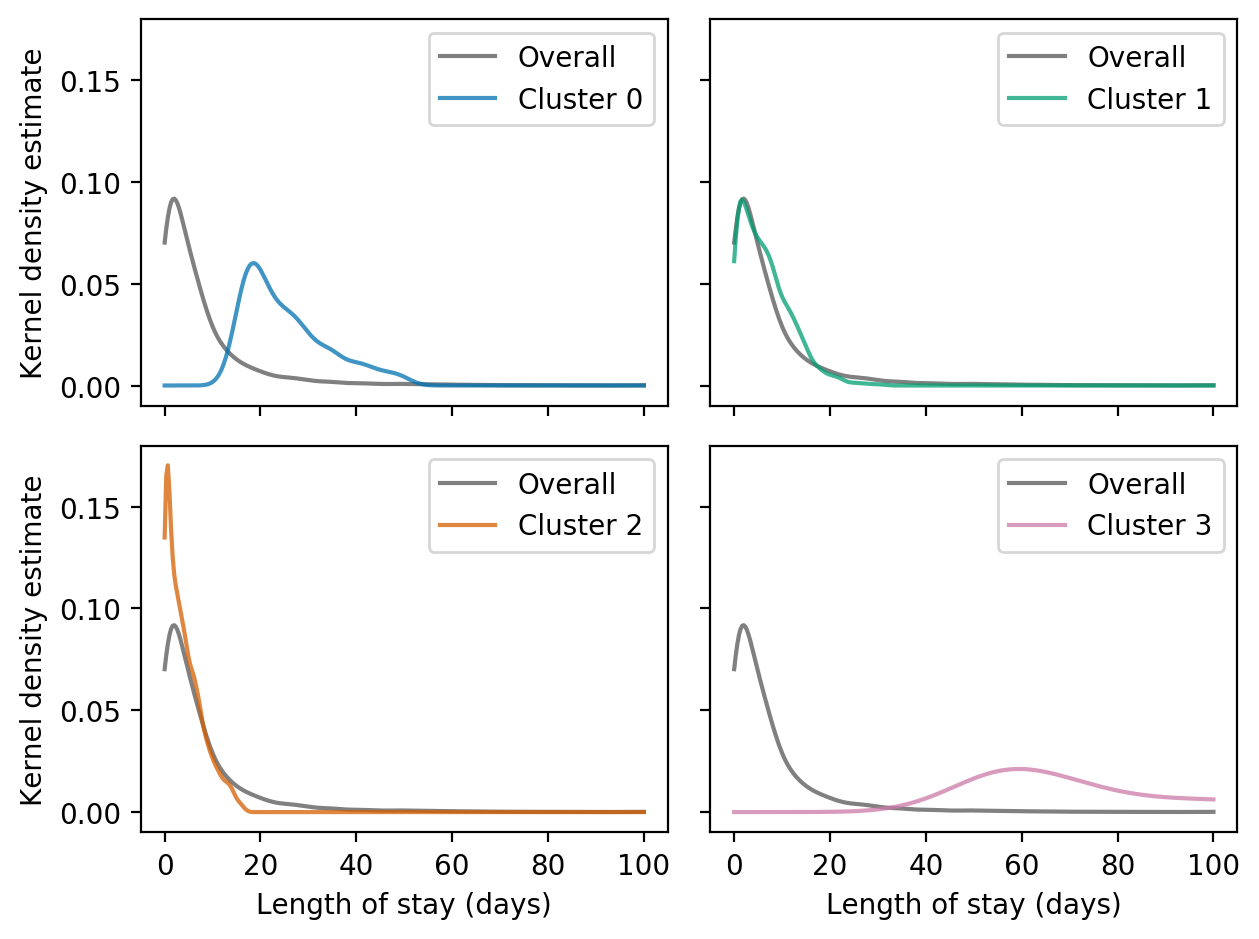

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

xs = np.linspace(0, 100, 300)

for pos, (ax, cluster) in enumerate(zip(axes, range(n_clusters))):

    kernel = stats.gaussian_kde(copd["true_los"])
    ax.plot(xs, kernel(xs), "gray", label="Overall")

    times = copd[copd["cluster"] == cluster]["true_los"]
    kernel = stats.gaussian_kde(times)

    ax.plot(
        xs,
        kernel(xs),
        color=colours[cluster],
        alpha=0.75,
        label=f"Cluster {cluster}",
    )

    ax.set_ylim(kde_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Kernel density estimate")

    ax.legend()
    plt.tight_layout()

plt.savefig("../img/cluster_los.pdf", transparent=True)

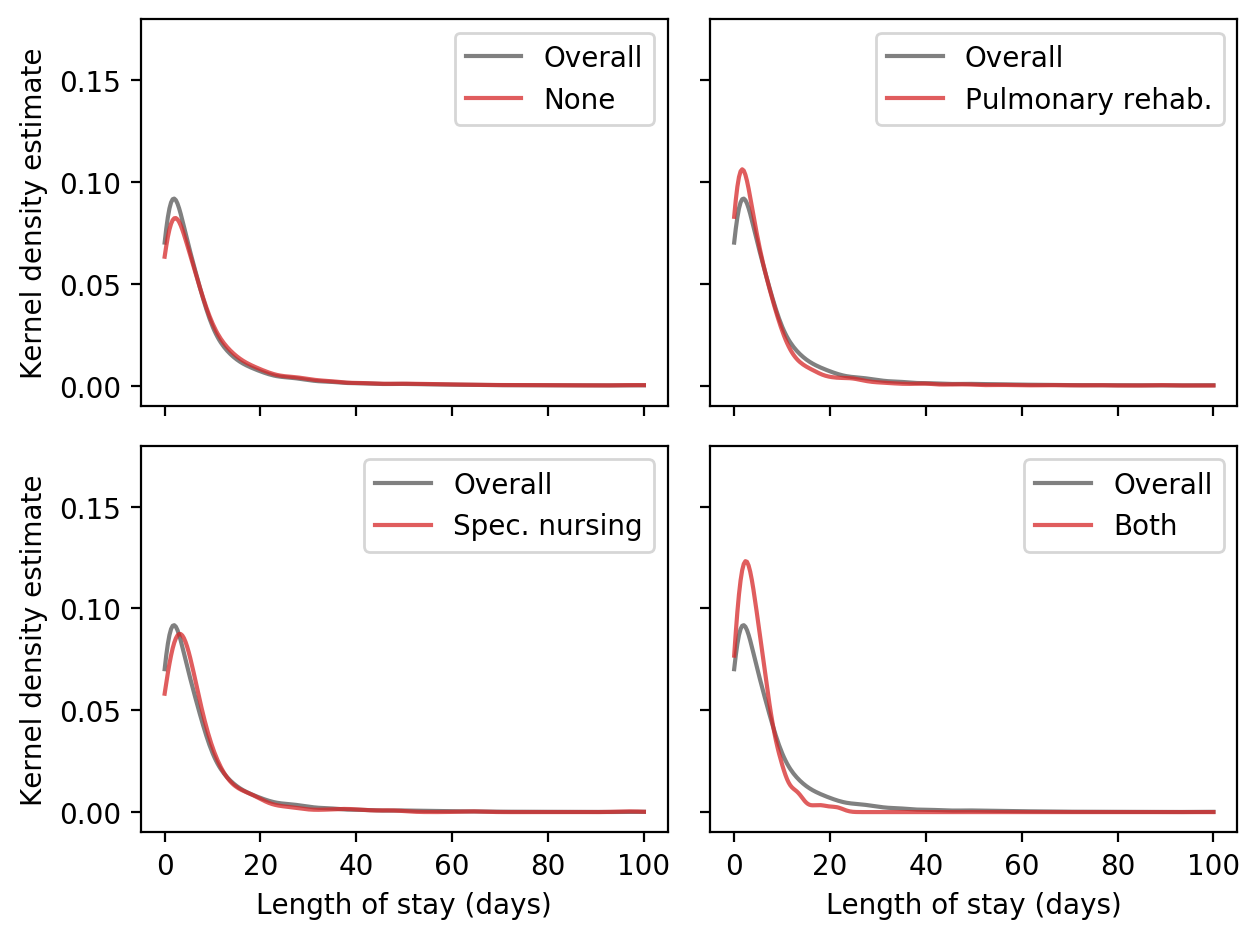

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
axes = axes.reshape(4)

intervention_labels = {"none": "None", "both": "Both", "pr": "Pulmonary rehab.", "sn": "Spec. nursing"}

xs = np.linspace(0, 100, 300)

for pos, (ax, intervention) in enumerate(zip(axes, ["none", "pr", "sn", "both"])):

    kernel = stats.gaussian_kde(copd["true_los"])
    ax.plot(xs, kernel(xs), "gray", label="Overall")

    times = copd[copd["intervention"] == intervention]["true_los"]
    kernel = stats.gaussian_kde(times)

    ax.plot(
        xs,
        kernel(xs),
        color="tab:red",
        alpha=0.75,
        label=intervention_labels[intervention],
    )

    ax.set_ylim(kde_ylims)
    if pos > 1:
        ax.set_xlabel("Length of stay (days)")
    if pos % 2 == 0:
        ax.set_ylabel("Kernel density estimate")

    ax.legend()
    plt.tight_layout()

plt.savefig("../img/intervention_los.pdf", transparent=True)

In [10]:
def histograms(data, column, group="cluster", density=True, colours=colours, bins=10):

    fig, axes = plt.subplots(ncols=2, nrows=2, dpi=200, sharex=True, sharey=True)
    axes = axes.reshape(4)

    column_labels = {
        "wimd": "Welsh Index of Multiple Deprivation",
        "charlson_gross": "Charlson Comorbidity Index",
        "n_copd_admissions_last_year": "COPD admissions in last year",
        "n_icds": "No. of ICDs",
        "age": "Age (years)",
        "spell_cost": "Cost of spell (£)"
    }
    
    str_ints = (x for x in range(10))
    for (label, values), ax in zip(copd.groupby(group)[column], axes):

        ax.hist(
            copd[column],
            bins=bins,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="Overall",
        )

        label_name = intervention_labels.get(label, f"Cluster {label}")
        if isinstance(label, str):
            label = next(str_ints)
            colour = "tab:red"
        else:
            colour = colours[label]

        ax.hist(
            values, bins=bins, alpha=0.5, facecolor=colour, density=True, label=label_name
        )

        if label > 1:
            ax.set_xlabel(column_labels[column])
        if label % 2 == 0:
            ax.set_ylabel("Frequency density")

        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../img/{group}_{column}.pdf", transparent=True)

/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/henrywilde/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in l

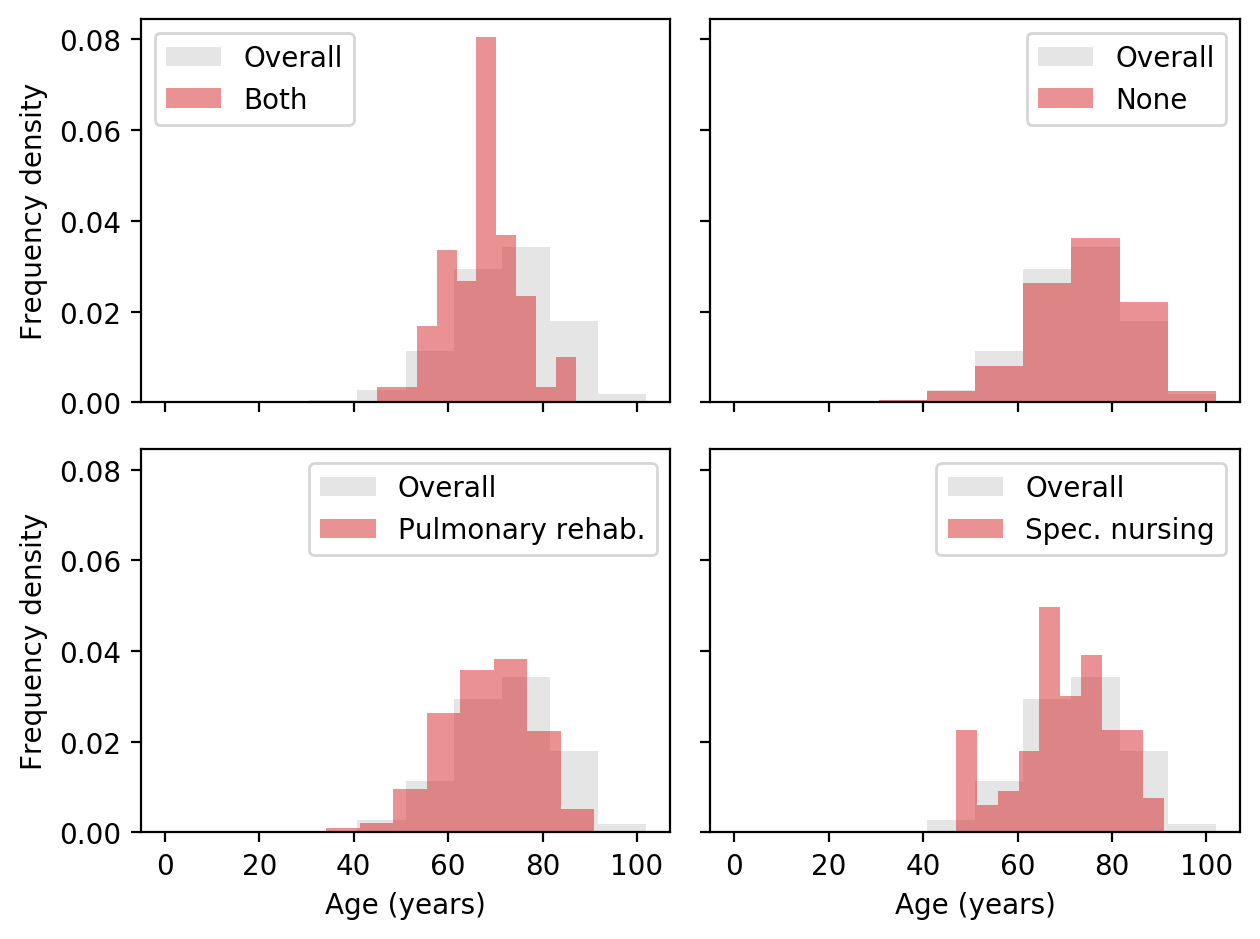

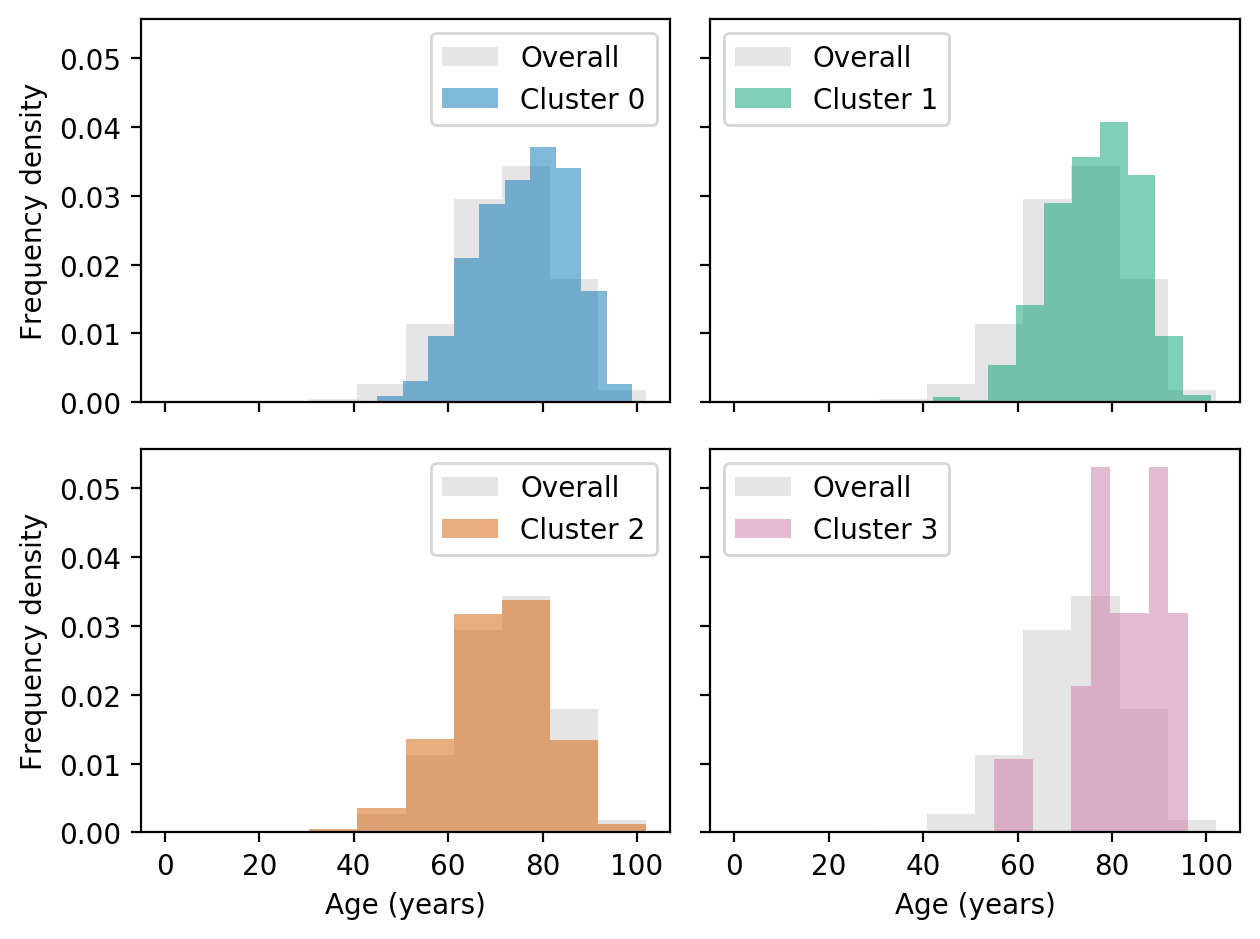

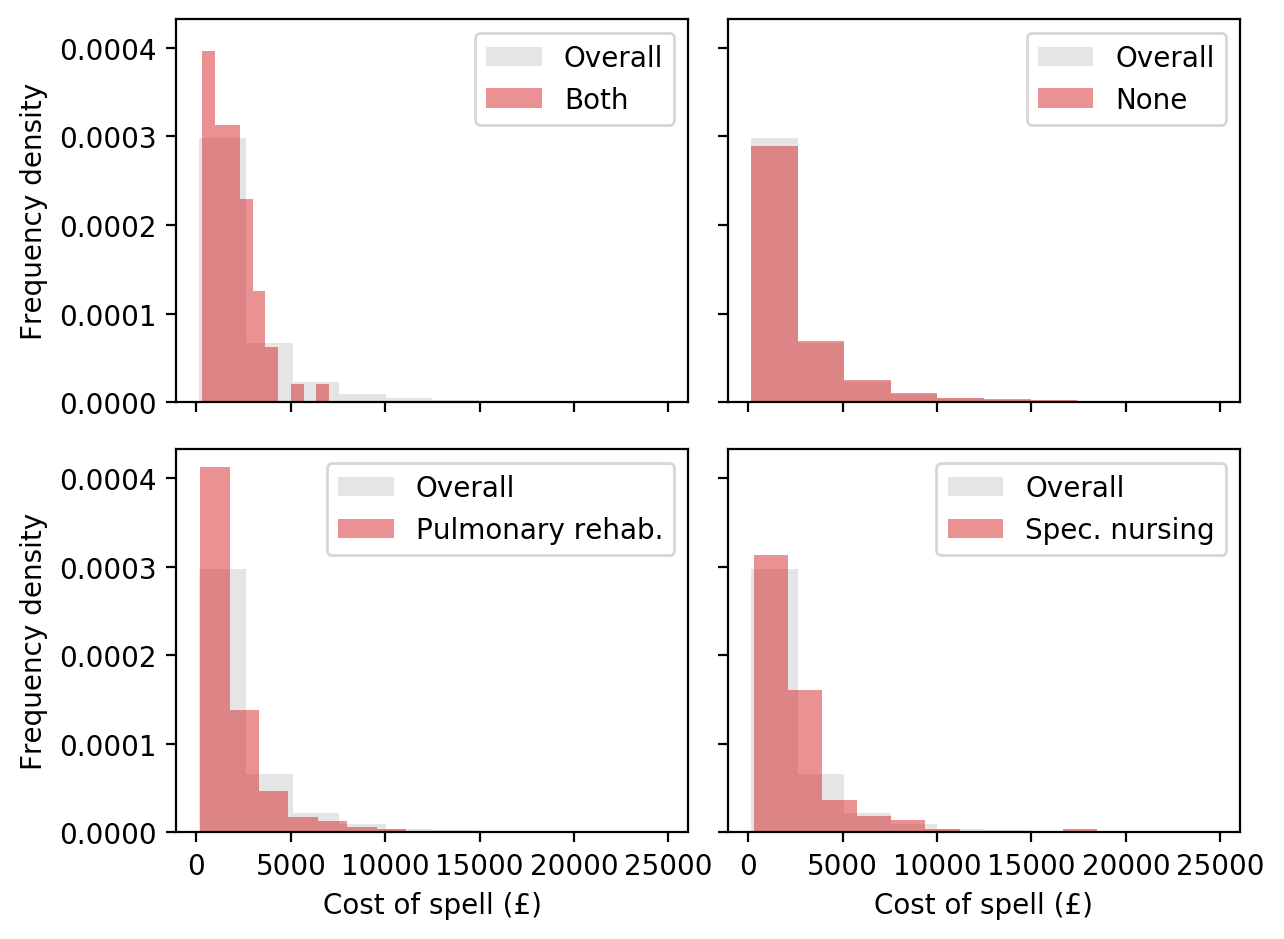

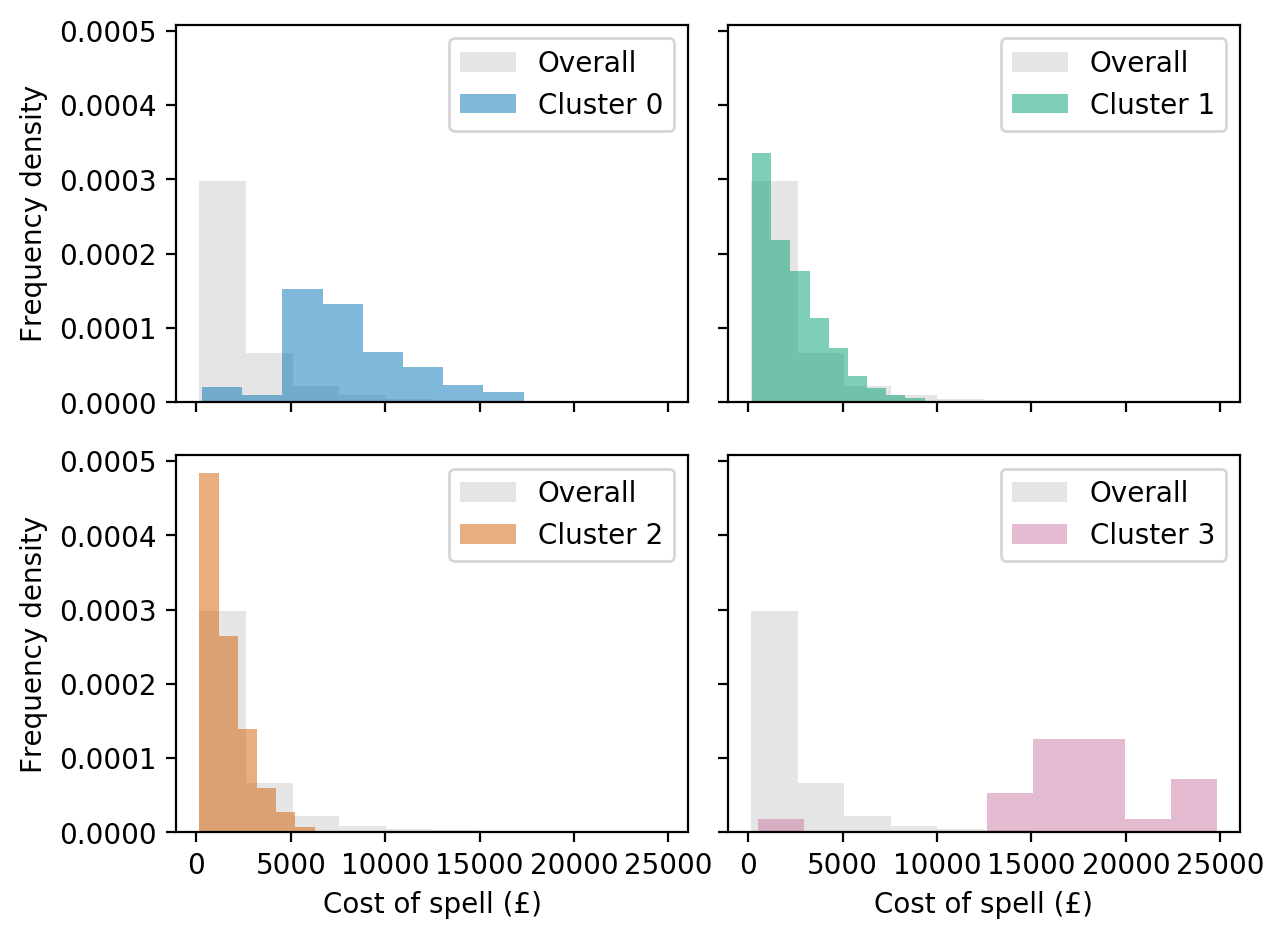

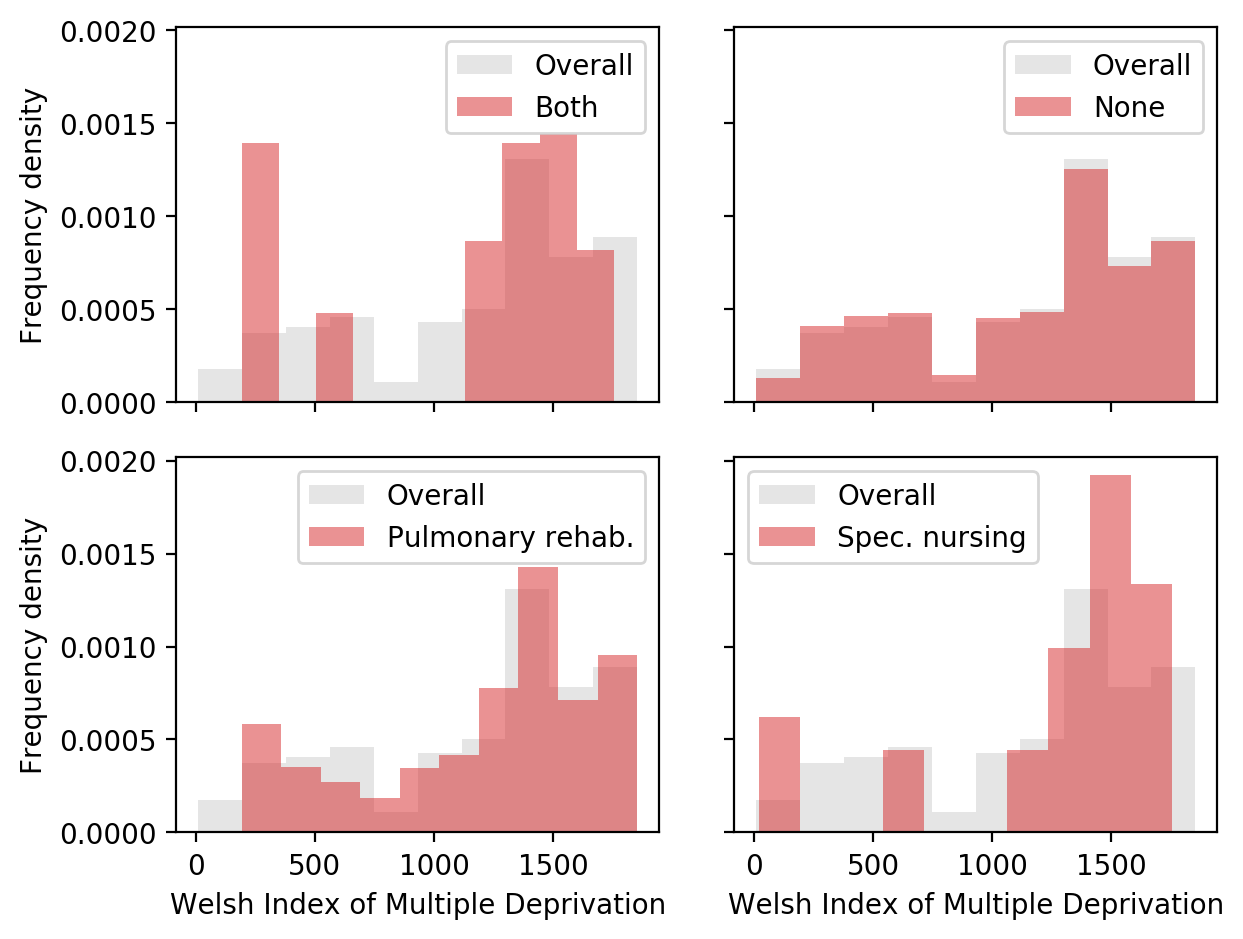

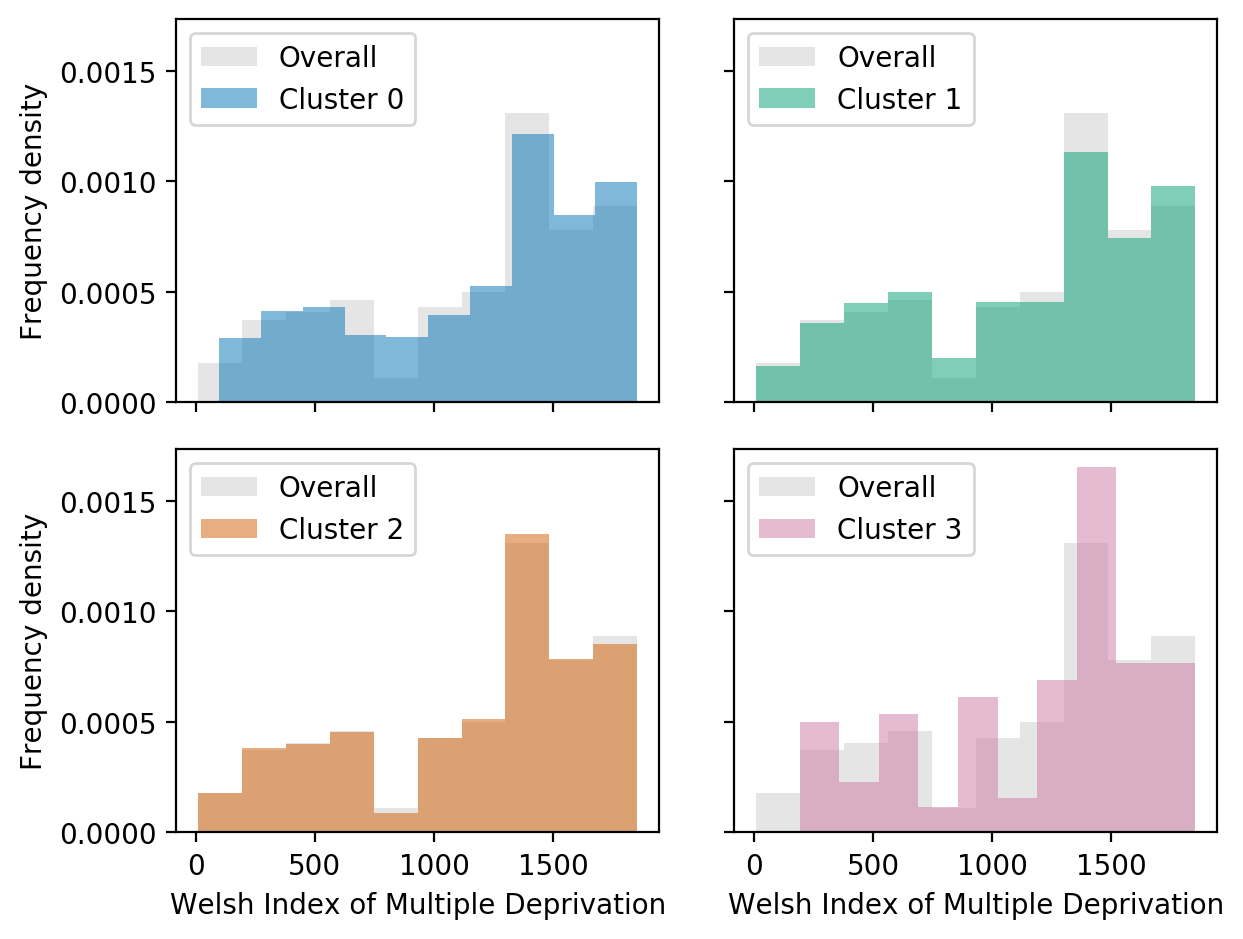

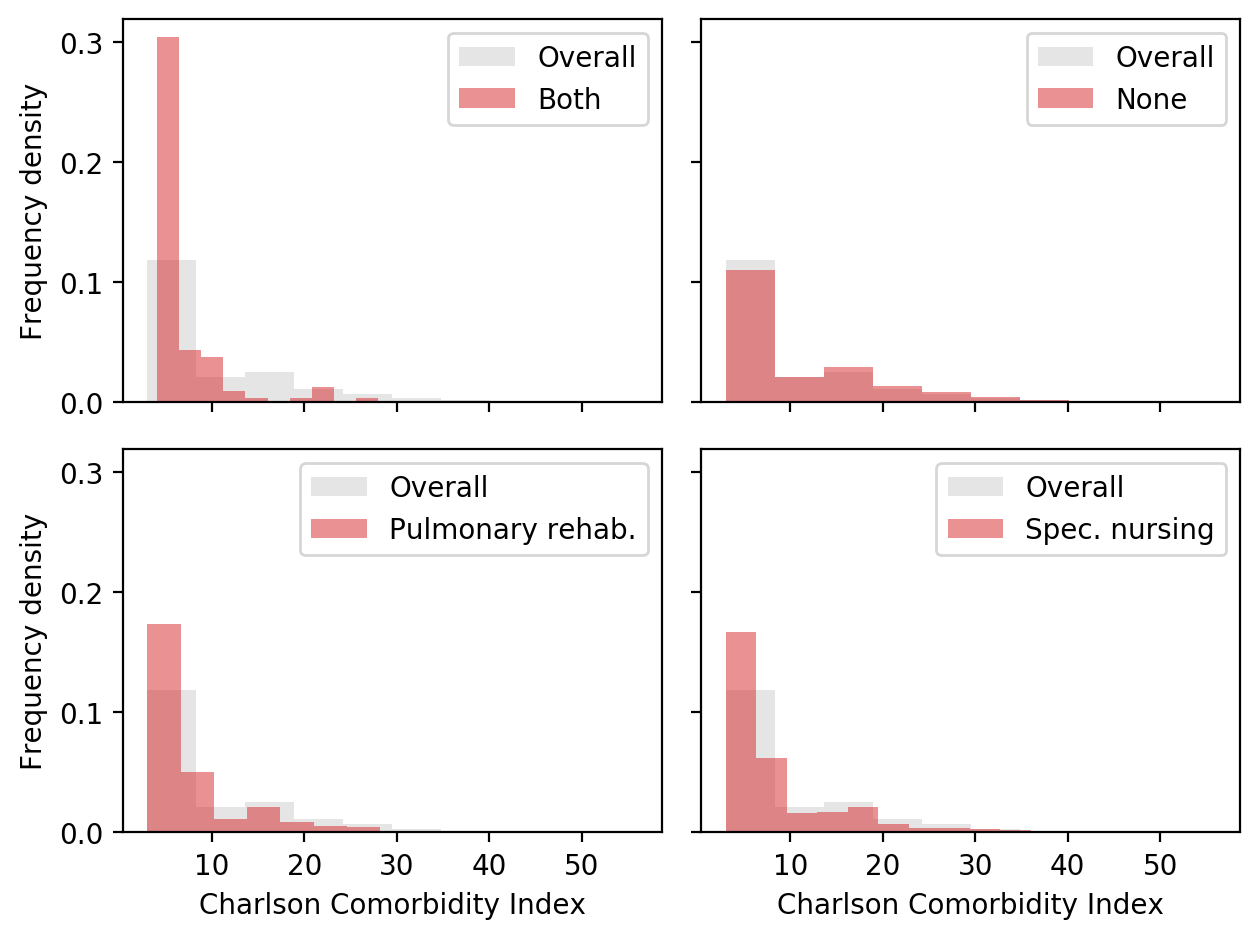

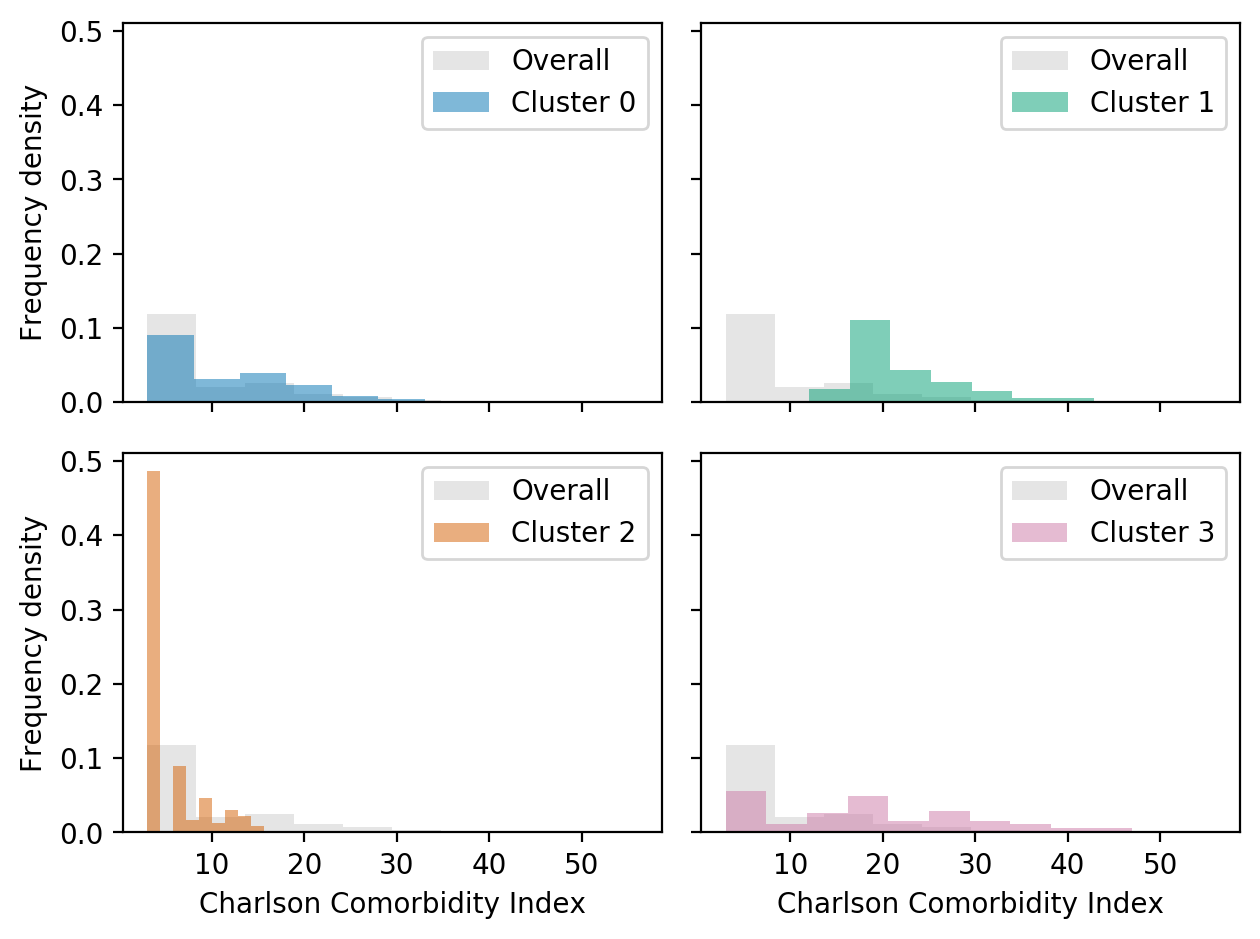

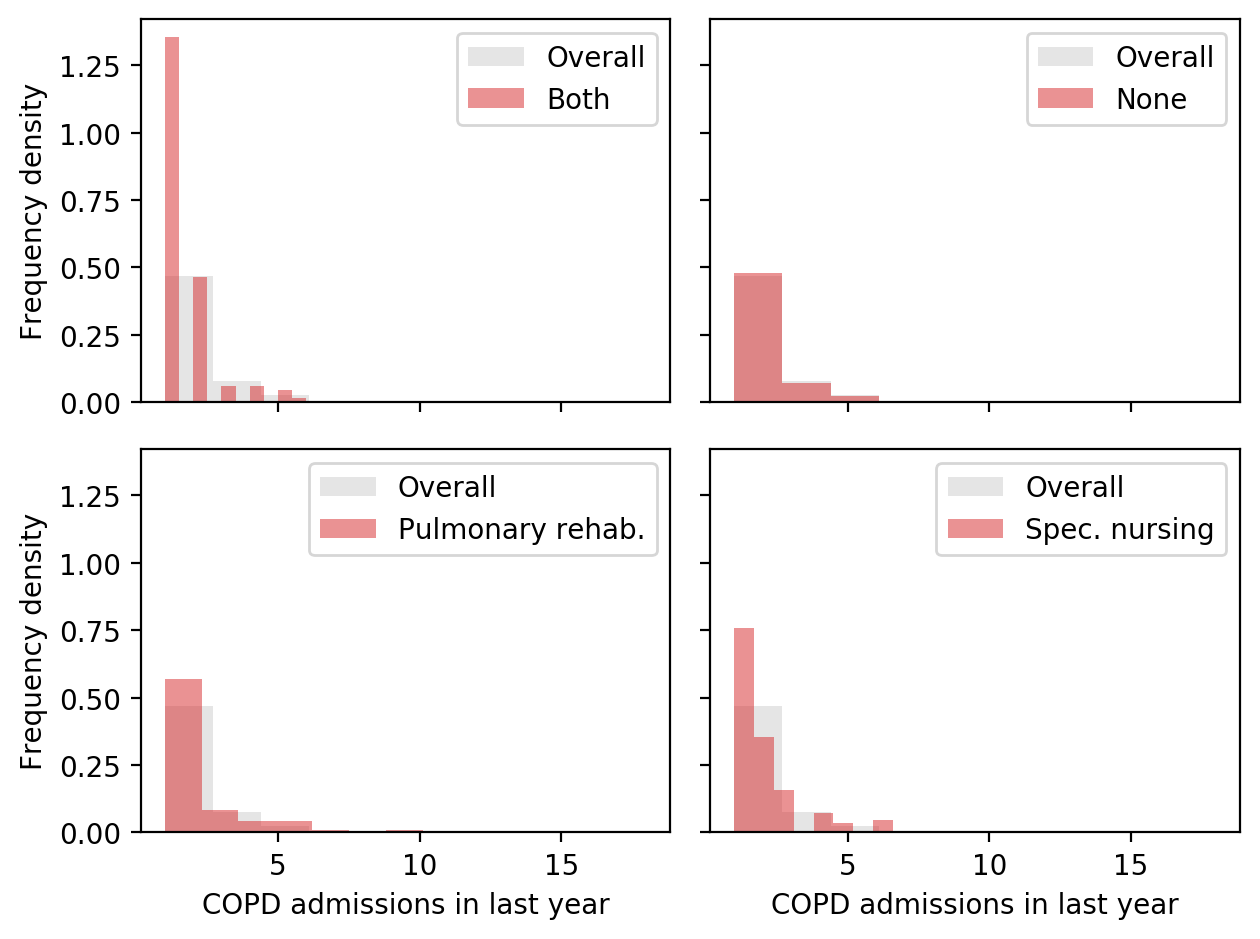

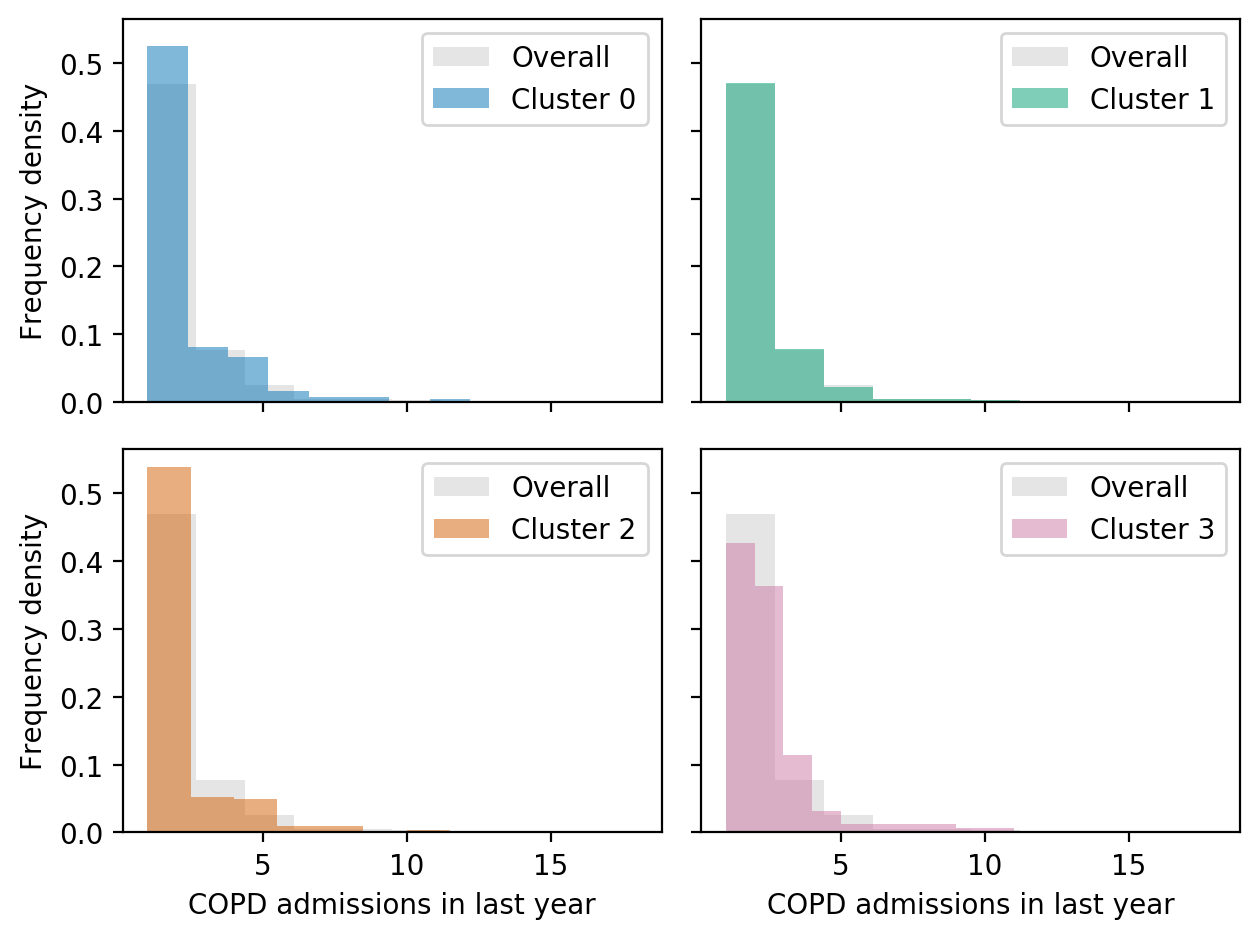

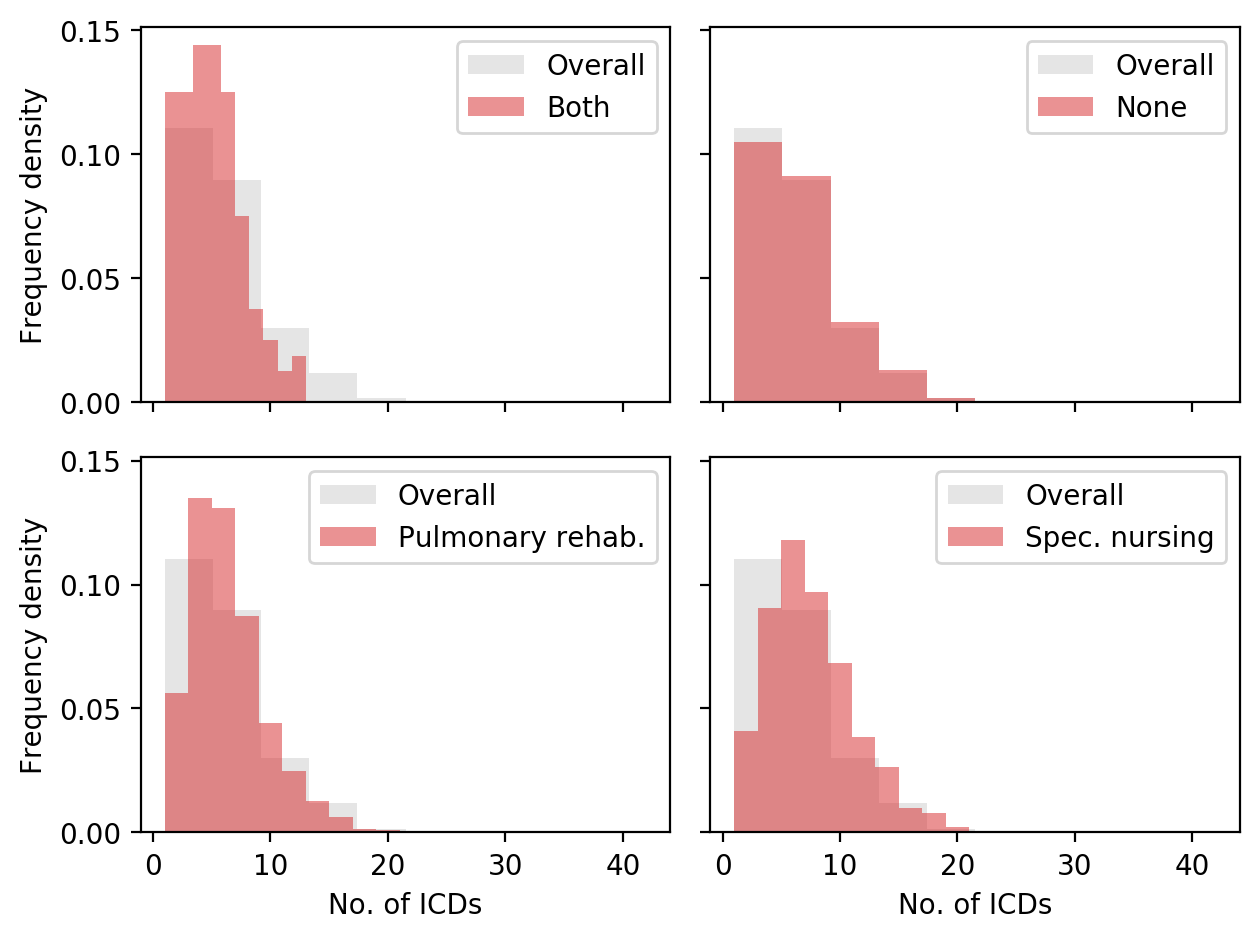

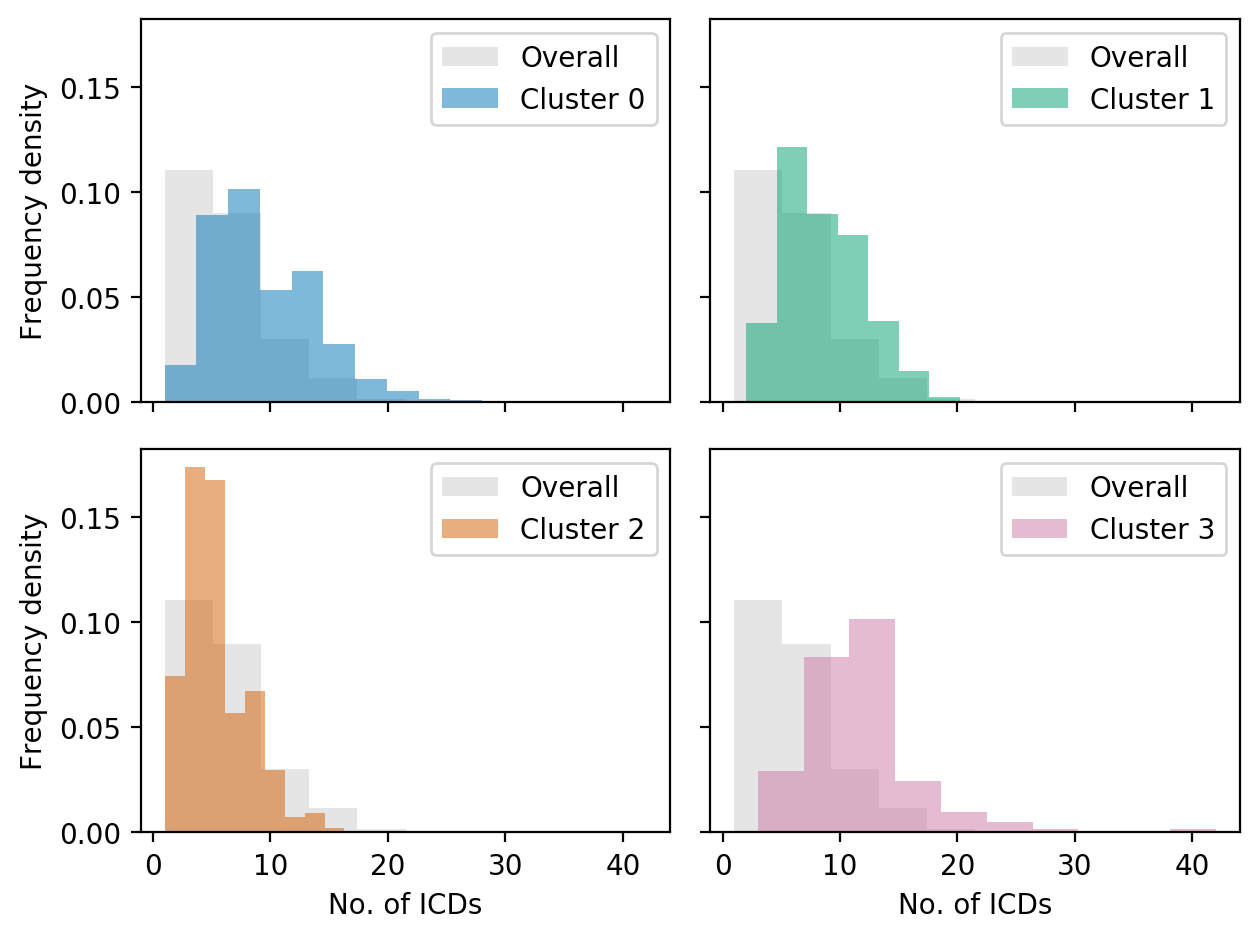

In [11]:
for col in [
    "age",
    "spell_cost",
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
]:
    histograms(copd, col, group="intervention")
    histograms(copd, col, group="cluster")

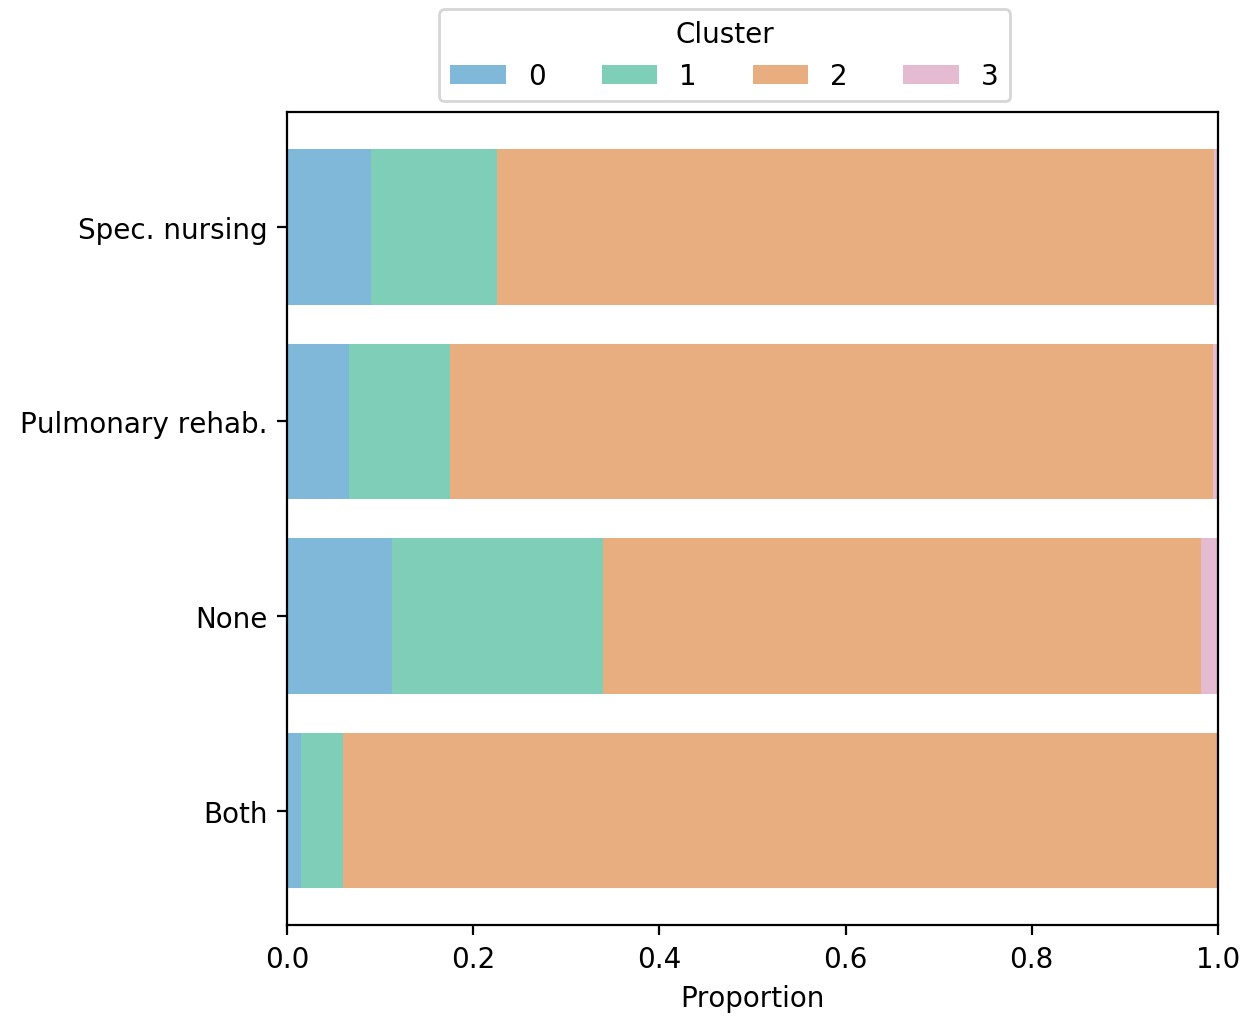

In [12]:
fig, ax = plt.subplots(dpi=200)

for intervention, values in copd.groupby("intervention")["cluster"]:

    left = 0
    handles, labels = [], []
    cluster_proportions = values.value_counts(normalize=True).reindex([0, 1, 2, 3]).fillna(0)
    for cluster, proportion in dict(cluster_proportions).items():
        colour = colours[cluster]
        ax.barh(intervention_labels[intervention], proportion, left=left, fc=colour, alpha=0.5, label=cluster)
        left += proportion
        if not cluster in handles:
            handles.append(cluster)
            labels.append(plt.matplotlib.patches.Patch(fc=colour, alpha=0.5))

ax.set_xlabel("Proportion")
fig.legend(labels, handles, bbox_to_anchor=[0.8, 1.08], ncol=4, title="Cluster")
plt.tight_layout()


In [13]:
cluster_attendances = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_attendances[label] = [cluster.groupby("patient_id")["n_copd_admissions_last_year"].mean().mean()]

cluster_mean_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].mean().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_mean_lengths[label] = [cluster.groupby("patient_id")["true_los"].mean().mean()]

cluster_min_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].min().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_min_lengths[label] = [cluster.groupby("patient_id")["true_los"].min().min()]

cluster_max_lengths = pd.DataFrame({"Population": [copd.groupby("patient_id")["true_los"].max().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_max_lengths[label] = [cluster.groupby("patient_id")["true_los"].max().max()]

cluster_nicds = pd.DataFrame({"Population": [copd.groupby("patient_id")["n_icds"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_nicds[label] = [cluster.groupby("patient_id")["n_icds"].median().median()]
    
cluster_ltcs = pd.DataFrame({"Population": [copd.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_ltcs[label] = [cluster.groupby("patient_id")[conditions].max().astype(bool).sum(axis=1).mean()]

cluster_charlsons = pd.DataFrame({"Population": [copd.groupby("patient_id")["charlson_gross"].median().mean()]})
for label, cluster in copd.groupby("cluster"):
    cluster_charlsons[label] = [cluster.groupby("patient_id")["charlson_gross"].median().median()]

In [14]:
cluster_characteristics = [
    cluster_attendances,
    cluster_min_lengths,
    cluster_mean_lengths,
    cluster_max_lengths,
    cluster_ltcs,
    cluster_nicds,
    cluster_charlsons,
]

overall_characteristic = pd.concat(cluster_characteristics, ignore_index=True)
overall_characteristic.index = [
    "COPD admissions in last year",
    "Min. LOS",
    "Mean LOS",
    "Max. LOS",
    "No. of LTCs",
    "Median no. ICDs",
    "Median CCI",
]

overall_characteristic = overall_characteristic[[0, 1, 2, 3, "Population"]]
overall_characteristic.index = [i + ", mean" for i in overall_characteristic.index]

In [15]:
overall_characteristic

,0,1,2,3,Population
"COPD admissions in last year, mean",1.912424,1.506656,1.305084,1.982340,1.289233
"Min. LOS, mean",12.822917,-0.004861,-0.020833,48.817361,5.408879
"Mean LOS, mean",25.304893,6.446681,3.793179,74.653468,7.474234
"Max. LOS, mean",51.360417,30.859028,16.940972,224.927778,10.398216
"No. of LTCs, mean",2.049412,3.097985,1.469254,2.701987,1.996559
"Median no. ICDs, mean",9.000000,8.000000,5.000000,11.000000,6.583158
"Median CCI, mean",9.000000,20.000000,4.000000,18.000000,9.720512


In [16]:
cluster_conditions = {}
for cluster, data in copd.groupby("cluster"):
    cluster_conditions[cluster] = data.groupby("patient_id")[conditions].max().astype(bool)


In [17]:
cluster_intervention_proportions = pd.DataFrame({"Population": copd["intervention"].value_counts(normalize=True)})
for cluster, values in copd.groupby("cluster")["intervention"]:
    proportions = values.value_counts(normalize=True).reindex(["none", "pr", "sn", "both"]).fillna(0)
    cluster_intervention_proportions[cluster] = proportions

cluster_intervention_proportions *= 100
new_index = [intervention_labels.get(i) + ", %" for i in cluster_intervention_proportions.index]
cluster_intervention_proportions.index = new_index

In [18]:
overall_condition = pd.DataFrame()
for label, data in cluster_conditions.items():
    overall_condition[label] = data.mean() * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean() * 100

overall_condition.index = [
    "Acute myocardial infection",
    "Cerebrovascular accident",
    "Congestive heart failure",
    "Connective tissue disorder",
    "Dementia",
    "Diabetes",
    "Liver disease",
    "Peptic ulcer",
    "Peripheral vascualar disease",
    "Pulmonary disease",
    "Cancer",
    "Diabetic complications",
    "Paraplegia",
    "Renal disease",
    "Metastatic cancer",
    "Severe liver disease",
    "HIV",
    "C. diff",
    "MRSA",
    "Obesity",
    "Sepsis",
]

overall_condition.index = [i + ", %" for i in overall_condition.index]

In [19]:
summary = pd.concat(
    [overall_characteristic, cluster_intervention_proportions, overall_condition], sort=False
).round(2)

index = pd.MultiIndex.from_tuples(
    [
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("Intervention prevalence", i) for i in cluster_intervention_proportions.index),
        *(("LTC prevalence", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population (mean)", "")]
)

summary.index = index
summary.columns = columns

summary.to_latex("../tex/summary.tex", multicolumn=False, bold_rows=True)

summary

Cluster          \
                                                                 0       1   
Characteristics         COPD admissions in last year, mean    1.91    1.51   
                        Min. LOS, mean                       12.82   -0.00   
                        Mean LOS, mean                       25.30    6.45   
                        Max. LOS, mean                       51.36   30.86   
                        No. of LTCs, mean                     2.05    3.10   
                        Median no. ICDs, mean                 9.00    8.00   
                        Median CCI, mean                      9.00   20.00   
Intervention prevalence None, %                              80.26   83.40   
                        Pulmonary rehab., %                  15.77   13.41   
                        Spec. nursing, %                      3.78    2.91   
                        Both, %                               0.18    0.29   
LTC prevalence          Acute myocardial infection, %        14.35   23.42   
                        Cerebrovascular accident, %           9.65   15.01   
                        Congestive heart failure, %          14.47   54.62   
                        Connective tissue disorder, %         5.18    5.07   
                        Dementia, %                           7.53   20.08   
                        Diabetes, %                          20.12   28.70   
                        Liver disease, %                      0.35    0.56   
                        Peptic ulcer, %                       1.76    1.04   
                        Peripheral vascualar disease, %       5.06    8.90   
                        Pulmonary disease, %                100.00  100.00   
                        Cancer, %                             8.12   13.69   
                        Diabetic complications, %             0.24    0.69   
                        Paraplegia, %                         1.29    3.96   
                        Renal disease, %                      8.59   22.52   
                        Metastatic cancer, %                  1.88    5.70   
                        Severe liver disease, %               0.24    0.63   
                        HIV, %                                0.00    0.00   
                        C. diff, %                            0.82    0.14   
                        MRSA, %                               0.35    0.07   
                        Obesity, %                            2.82    3.75   
                        Sepsis, %                             2.12    1.25   

                                                                            \
                                                                 2       3   
Characteristics         COPD admissions in last year, mean    1.31    1.98   
                        Min. LOS, mean                       -0.02   48.82   
                        Mean LOS, mean                        3.79   74.65   
                        Max. LOS, mean                       16.94  224.93   
                        No. of LTCs, mean                     1.47    2.70   
                        Median no. ICDs, mean                 5.00   11.00   
                        Median CCI, mean                      4.00   18.00   
Intervention prevalence None, %                              65.76   89.81   
                        Pulmonary rehab., %                  27.96    8.92   
                        Spec. nursing, %                      4.63    1.27   
                        Both, %                               1.66    0.00   
LTC prevalence          Acute myocardial infection, %        10.86   16.56   
                        Cerebrovascular accident, %           1.21   19.21   
                        Congestive heart failure, %           0.00   27.15   
                        Connective tissue disorder, %         4.01    4.64   
                        Dementia, %                           0.00   25.17   
  